In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
np.random.seed(100)

# 近似ベイズ推論：サンプリングに基づく推論手法
- パラメータの推論が解析的に行えないケースがある
  - e.g. モデルが複雑、非線形、共役関係にない分布でモデルを設計
- サンプリングに基づく推論：求めたい分布$p(\Theta | \mathcal{D})$から何らかの方法でサンプルを得ることで、その分布の統計的性質を知る

ここでは、サンプリングに基づく近似推論の一つとして、高次元の空間で効率的にサンプリングを行う手段である「マルコフ連鎖モンテカルロ法(Markov chain Monte Carlo method, MCMC)」と呼ばれている手法を実装してみる。
MCMC法はいくつかのアルゴリズムが提案されている。ここでは、基本的なアルゴリズムの一つである「ギブスサンプリング(Gibbs sampling)」を実装する。

MCMC法のアイディアは、サンプルを取り出したい分布が定常分布$p(z)$に分布収束するような遷移確率$p(z_t | z_{t-1})$を設計するというアイディアで作られている。

## ギブスサンプリング(Gibbs sampling)
ギブスサンプリングは、以下の条件を満たす問題の場合に、メトロポリス法などと比較して効率的にサンプリングを行うことができる手法。

- 複数の確率変数($\mathbf{Z} = \{\mathbf{Z}_1, \mathbf{Z}_2, \cdots , \mathbf{Z}_M\}$)を持ったモデルである
- 確率変数$\mathbf{Z}$を部分集合に分けた条件付き分布から$\mathbf{Z}_i$をサンプルすることが容易なように条件付き分布$p(\mathbf{Z}_i | \mathbf{Z}_{-i})$を構築することができる
  - $\mathbf{Z}_{-i}$は$\mathbf{Z}_i$を除いた確率変数の集合とする

適用できるか否かは条件があるが、$\mathbf{Z}$が多数ある場合などで有効な手法。

### アルゴリズム
- サンプルを得たい目標分布 : $p(\mathbf{Z})$
  - 確率変数$\mathbf{Z}$ : $\mathbf{Z} = \{\mathbf{Z}_1, \mathbf{Z}_2, \cdots , \mathbf{Z}_M\}$
- 確率変数$\mathbf{Z}$の部分集合の条件付き分布 : $p(\mathbf{Z}_i | \mathbf{Z}_{-i})$

以下の手順でサンプル$\mathbf{z^{(l)}}$を取得する。

1. $\mathbf{Z}$を適当に初期化
2. サンプル回数分繰り返し
  1. 確率変数$\mathbf{Z}$の部分集合ごとに繰り返し
    1. $\mathbf{Z}_i$を条件付き分布$p(\mathbf{Z}_i | \mathbf{Z}_{-i})$からサンプル（$\mathbf{Z}_*$）
    2. $\mathbf{Z}_i$をサンプルした点($\mathbf{Z}_*$)に置き換えてAに戻る

メトロポリス法と異なりサンプルした点が必ず受容されるため、ギブスサンプリングが使えればメトロポリス法などと比較すると効率良くサンプルを得ることができる。

# ギブスサンプリングによる確率分布の近似推論の実装

## 二次元ガウス分布からのサンプリング
二次元のガウス分布を例にギブスサンプリングを実装する。
二次元のガウス分布がどのような性質の分布であるかは既知であるが、ここでは例として、1次元のガウス分布からサンプルを得ることは容易だが２次元のガウス分布からサンプルを得ることは難しいものとする。


二次元ガウス分布
$$
\begin{align*}
  x = \left(\begin{array}{c}
        {x_{1}} \\ {x_{2}}
    \end{array}\right) 
    \sim \mathcal{N} \left( \left(\begin{array}{c}{\mu_{1}} \\ {\mu_{2}}\end{array}\right), \left(\begin{array}{cc}{\Sigma_{11}} & {\Sigma_{12}} \\ {\Sigma_{21}} & {\Sigma_{22}}\end{array}\right)\right)
\end{align*}
$$


$x_1, x_2$のそれぞれの条件付き分布は以下の通り。
（計算の詳細は略。「PRML(上)」や「ガウス過程と機械学習」などを参照）

$$
\begin{align*}
  p\left(x_{2} | x_{1} \right) = \mathcal{N}\left(\mu_{2} + \Sigma_{21} \Sigma_{11}^{-1} \left(x_{1} - \mu_{1} \right), 
  \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}\right)
\end{align*}
$$

逆は

$$
\begin{align*}
  p\left(x_{1} | x_{2} \right) = \mathcal{N}\left(\mu_{1} + \Sigma_{12} \Sigma_{22}^{-1} \left(x_{2} - \mu_{2} \right), 
  \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{21}\right)
\end{align*}
$$


In [3]:
mu = [0.0, 0.0]
s = [[1.0, 0.5], [0.5, 1.0]]

### 解析解

In [4]:
# 解析解
n_sample = 1000
zs_a = np.random.multivariate_normal(mean=mu, cov=s, size=n_sample)

### 近似解

In [5]:
# ギブスサンプリング
n_sample = 1000
#z = list(stats.uniform(loc=-4, scale=8).rvs(size=2))
z = [3, -2]
zs = [z.copy()] # initialize

for i in tqdm(np.arange(n_sample)):
    mu0 = mu[0] + s[0][1]/s[1][1]*(z[1]-mu[1])
    v0 = s[0][0] - s[0][1]/s[1][1]*s[1][0]
    z[0] = np.random.normal(loc=mu0, scale=v0, size=1)
    zs.append(z.copy())
    
    mu1 = mu[1] + s[1][0]/s[0][0]*(z[0]-mu[0])
    v1 = s[1][1] - s[1][0]/s[0][0]*s[0][1]
    z[1] = np.random.normal(loc=mu1, scale=v1, size=1)
    zs.append(z.copy())
zs_gs = np.array(zs)

100%|██████████| 1000/1000 [00:00<00:00, 19438.95it/s]


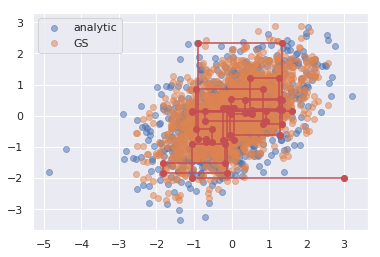

In [6]:
plt.scatter(zs_a[:,0], zs_a[:,1], alpha=0.5, label='analytic')
plt.scatter(zs_gs[:,0], zs_gs[:,1], alpha=0.5, label='GS')
plt.legend()
plt.plot(zs_gs[:50,0], zs_gs[:50,1], 'o-', c='r')

## 線形回帰モデル
次に、ギブスサンプリングの適用例として線形回帰モデルの近似解を算出する。

線形回帰モデルの同時分布は以下の通り。

$$
\begin{eqnarray}
    p(\mathbf{w}, \mathbf{Y} | \mathbf{X}) = p(\mathbf{w})p(\mathbf{Y} | \mathbf{X}, \mathbf{w}) = p(\mathbf{w}) \prod^{N}_{n=1} p(y_n | \mathbf{x}_{n}, \mathbf{w})
\end{eqnarray}
$$

ここで、観測$y_n$は変数$x_n$を基底関数群$\mathbf{\phi}(x)=\{\phi_1(x), \phi_2(x), \cdots, \phi_M(x)\}^{T}$と重み$\mathbf{w}=\{w_1, w_2, \cdots, w_M\}^{T}$の内積で表現し、ガウスノイズが乗って観測されるとする。

$$
p(y_n | \mathbf{x}_{n}, \mathbf{w}) = \mathcal{N}(y_{n} | \mathbf{w}^{T}\phi(\mathbf{x}_n), \sigma^{2}_{y})
$$

ここで簡単のために、分散$\sigma^{2}_{y}$は固定のパラメータ（既知）とする。

重み$\mathbf{w}$の事前分布は平均0のガウス分布とする。

$$
p(\mathbf{w}) = \mathcal{N}(\mathbf{w} | 0, \sigma^{2}_{w}\mathbf{I})
$$

分散$\sigma^{2}_{w}$は固定のパラメータとする。


In [7]:
def polynomial(x, degree):
    return [np.power(x, d) for d in np.arange(0, degree+1)]

### データの作成
上記のモデルに従ってデータを作成してみる。

ここでは、真の関数は３次の多項式とする。

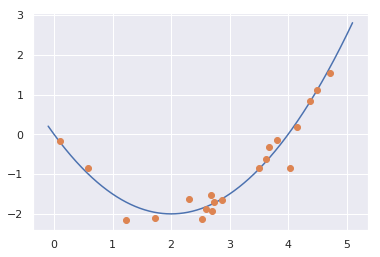

In [8]:
def true_func(x, params):
    y = np.dot(params['w'], polynomial(x, degree=(len(params['w'])-1)))
    return y
def observation_model(x, var=1.0, tfunc_params=None):
    ty = true_func(x, tfunc_params)
    y = np.random.normal(loc=ty, scale=np.sqrt(var), size=1)
    return y

xmin,xmax = 0, 5
sample_x = xmin + (xmax-xmin)*np.random.rand(20) # 純粋にランダムにサンプル

true_func_params = {'w':[0.0, -2.0, 0.5]}
var_y = 0.1
sample_y = list(map(lambda x:observation_model(x, var=var_y, tfunc_params=true_func_params), list(sample_x)))

# plot
fig = plt.figure(figsize=(6, 4))
ax = fig.subplots(1,1)
xs = np.linspace(xmin-0.1, xmax+0.1, 1000)
tys = list(map(lambda x:true_func(x, params=true_func_params), xs))
ax.plot(xs, tys, '-')
ax.plot(sample_x, sample_y, 'o')

### 解析解
$\mathbf{w}, y$が共にガウス分布に従うと仮定するため、$p(\mathbf{w} | \mathbf{Y}, \mathbf{X})$は厳密解を得ることができる。

$$
\begin{align}
    p(\mathbf{w} | \mathbf{Y}, \mathbf{X}) &\propto p(\mathbf{w})p(\mathbf{Y}|\mathbf{w}, \mathbf{X}) \\
     &= \mathcal{N}(y_{n} | \mathbf{w}^{T}\phi(\mathbf{x}_n), \sigma^{2}_{y}) \mathcal{N}(\mathbf{w} | 0, \sigma^{2}_{w}\mathbf{I}) \\
     &= \mathcal{N}(\mathbf{w} | \hat{\boldsymbol{\mu}}, \hat{\mathbf{\Sigma}}) \\
\end{align}
$$

ここで、

$$
\begin{align}
    \hat{\mathbf{\Sigma}}^{-1} &= \sigma_{y}^{-2} \sum_{n=1}^{N} \phi\left(\mathbf{x}_{n}\right) \phi\left(\mathbf{x}_{n}\right)^{\top}+\sigma_{w}^{-2} \mathbf{I} \\ 
    \hat{\boldsymbol{\mu}} &= \hat{\mathbf{\Sigma}} \sigma_{y}^{-2} \sum_{n=1}^{N} y_{n} \phi\left(\mathbf{x}_{n}\right)
\end{align}
$$


In [9]:
# 解析解
n_degree = 2 # モデルの次数
var_w = 0.1  # wの事前分布の分散

# 事後分布の分散共分行列
def outer_feature(x, degree=n_degree):
    feature = polynomial(x=x, degree=degree)
    return np.outer(feature, feature)
sum_feature = sum(map(outer_feature, sample_x))
S_hat_inv = (1.0/var_y) * sum_feature + (1.0/var_w) * np.identity((n_degree+1))
S_hat = np.linalg.inv(S_hat_inv)

# 事後分布の平均ベクトル
sum_yf = sum(map(lambda xy:np.array(polynomial(x=xy[0], degree=n_degree)) * xy[1], zip(sample_x, sample_y)))
tmp_ar = (1.0/var_y) * sum_yf
mu_hat = (np.dot(S_hat, tmp_ar[:,np.newaxis])).flatten()

In [10]:
print(mu_hat)
sample_post_ws = np.random.multivariate_normal(mean=mu_hat, cov=S_hat, size=1000)

[-0.46813822 -1.48695932  0.39586872]


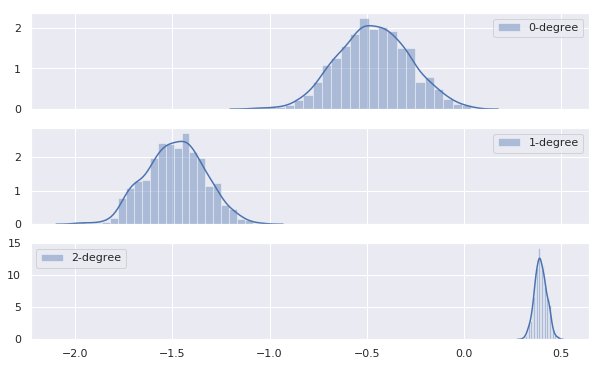

In [11]:
fig = plt.figure(figsize=(10, 2*(n_degree+1)))
ax = fig.subplots((n_degree+1),1, sharex=True)
if n_degree < 1:
    ax = [ax]

for i in range(n_degree+1):
    sns.distplot(sample_post_ws[:,i], ax=ax[i], label='{}-degree'.format(i))
    ax[i].legend()

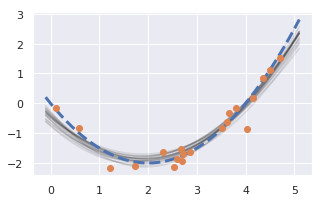

In [12]:
# 事後分布からwをサンプル
sample_post_ws = np.random.multivariate_normal(mean=mu_hat, cov=S_hat, size=20)

# plot
fig = plt.figure(figsize=(5, 3))
ax = fig.subplots(1,1)

sample_prior = list(map(lambda x:np.dot(sample_post_ws, polynomial(x=x, degree=n_degree)), xs))
ax.plot(xs, sample_prior, '-', c='#000000', alpha=0.1)
ax.plot(xs, tys, '--', lw=3)
ax.plot(sample_x, sample_y, 'o')

### 近似解
厳密解を得ることはできたが、ギブスサンプリングを利用して近似解も算出してみる。

この問題では、$\mathbf{w}$が複数ある。ここでは、多項式の次数毎の重み$w_i$をそれぞれサンプルすることを考える。厳密解は多変数の正規分布となったが、$p(w_i|w_{-i})$は確率変数が１次元のガウス分布となる。
なお、$w_{-i}$は$w_i$を除いた確率変数の集合とする。

$$
\begin{align}
    p(w_i | w_{-i}, \mathbf{Y}, \mathbf{X}) &\propto p(w_i | w_{-i})p(Y|w_i, w_{-i}, X) \\
     &= p(w_i) \prod^{N}_{n=1} p(y_n | w_i, w_{-i}, x_n) \\
     &= \mathcal{N}(w_i | 0, \sigma^2_w) \prod^{N}_{n=1} \mathcal{N}(y_n | w_i\phi_i(x_n) + w_{-i}^{T}\phi_{-i}(x_n), \sigma^2_{y}) \\
     &= \mathcal{N}(w_i | \hat{m}, \hat{\sigma}^2)
\end{align}
$$

ということで、$w_i$の条件付き分布はガウス分布となる。
ここで、平均、分散は以下の通り。

$$
\begin{align}
    \hat{\sigma}^{-2} &= \sigma^{-2}_w + \sigma^{-2}_y\sum^{N}_{n=1} \phi^2(x_n) \\
    \hat{m} &= \left( \sum^{N}_{n=1} y_n\phi_i(x_n) - \sum^{N}_{n=1} w_{-i}\phi_{-i}(x_n) \phi_i(x_n) \right) \sigma^{-2}_y \hat{\sigma}^{2}
\end{align}
$$

In [13]:
def feature_i(x, degree, n_degree):
    return polynomial(x=x, degree=n_degree)[degree]

def yf_i(y, x, degree, n_degree):
    return y * polynomial(x=x, degree=n_degree)[degree]

def af_i(x, w, degree, n_degree):
    feat = polynomial(x, n_degree)
    feat_i = feat.pop(degree)
    w_tmp = w.copy()
    w_i = w_tmp.pop(degree)
    alpha = np.dot(w_tmp, feat)
    return alpha * feat_i


In [14]:
# ギブスサンプリング
n_degree = 2 # モデルの次数

n_sample = 1000
n_burn = 300
w = list(np.random.normal(loc=0, scale=var_w, size=n_degree+1))
ws = [w.copy()] # Initialize

for i in tqdm(np.arange(n_sample)):
    for idx in range(n_degree+1):
        sum_feature = sum(map(lambda x:feature_i(x, idx, n_degree)**2, sample_x))
        inv_sig_hat = (1./var_w) + (1./var_y) * sum_feature
        sig_hat = 1. / inv_sig_hat
        tmp1 = sum(map(lambda xy:yf_i(xy[1], xy[0], idx, n_degree), zip(sample_x, sample_y)))
        tmp2 = sum(map(lambda x:af_i(x, w, idx, n_degree) , sample_x))
        mu_hat = (tmp1 - tmp2) * (1./var_y) * sig_hat
        w[idx] = np.random.normal(mu_hat, np.sqrt(sig_hat))[0]
    ws.append(w.copy())
ws = np.array(ws)

100%|██████████| 1000/1000 [00:03<00:00, 317.28it/s]


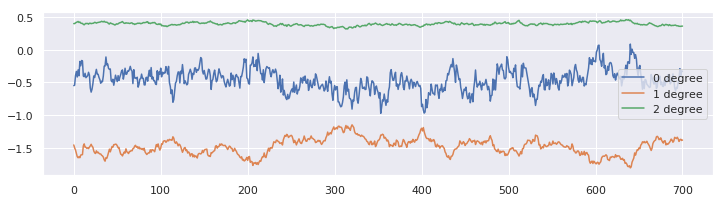

In [15]:
fig = plt.figure(figsize=(12, 3))
ax = fig.subplots(1,1)

for i in np.arange(n_degree+1):
    ax.plot(ws[n_burn:,i], label='{} degree'.format(i))
ax.legend()

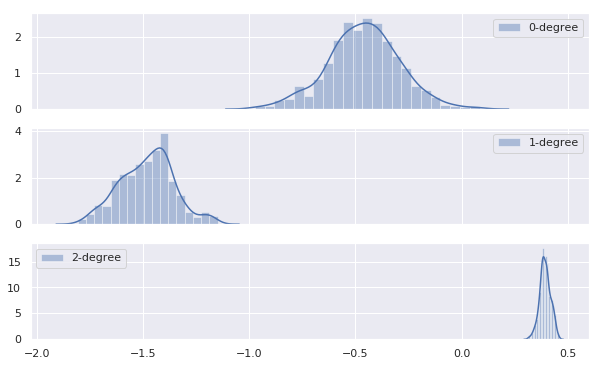

In [16]:
fig = plt.figure(figsize=(10, 2*(n_degree+1)))
ax = fig.subplots((n_degree+1),1, sharex=True)
if n_degree < 1:
    ax = [ax]

for i in range(n_degree+1):
    sns.distplot(ws[n_burn:,i], ax=ax[i], label='{}-degree'.format(i))
    ax[i].legend()

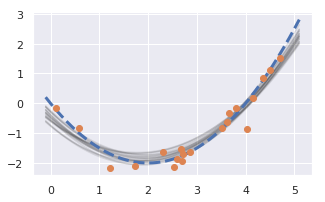

In [17]:
# 事後分布からwをサンプル
rand_idx = np.random.choice(n_sample-n_burn, 20, replace=False) + n_burn
sample_post_ws_gs = ws[rand_idx, :]

# plot
fig = plt.figure(figsize=(5, 3))
ax = fig.subplots(1,1)

sample_prior = list(map(lambda x:np.dot(sample_post_ws_gs, polynomial(x=x, degree=n_degree)), xs))
ax.plot(xs, sample_prior, '-', c='#000000', alpha=0.1)
ax.plot(xs, tys, '--', lw=3)
ax.plot(sample_x, sample_y, 'o')